# Path finding in environment with obstacles using Markov Decision Processes

This notebook presents a solution to a problem where a drone must navigate through a cave filled with obstacles (stalagmites and stalactites) to safely reach a finish point. The task is a pathfinding problem in a **fully observable** environment, using **Markov Decision Processes** to model the problem and the **Value Iteration** algorithm to solve it. The notebook interactively demonstrates solutions for different hyperparameter values, allowing to observe the effects of tweaking these hyperparameters.

Contents:

- MDP classes
- Value Iteration algorithm
- Results with visualizations


In [51]:
from mdp import MDP, GridMDP
from mdp import value_iteration, best_policy, expected_utility
from visualization import GridMDPVisualizer, InteractivePlot
from utils import grid_1, grid_2, grid_3
from notebook import print_source

# MDP class

This section presents the MDP classes used to represent a pathfinding problem as a Markov Decision Process (MDP), store important data, and provide a useful interface.

There is a base class, `MDP`, from which the `GridMDP` class is derived to work with the 2D environment of the cave with obstacles.

The `MDP` class does not include the algorithm for the solution, it is purely a data class to encode the problem into an MDP representation.

To encode the problem into an MDP, we define:
- state space - a set of states where the drone can be.
- transition model - which describes the outcome of each action in each state.
- list of actions - a set of actions that can be made in each state.
- rewards - from each state we can transition to another state, and each transition is associated with a reward value.
- action probability distribution - each action has the probability to do certain outcomes. For example, if the probability of moving forward action is **0.8**, then the probability that our drone will be unstable and move in another direction instead is **0.2**. Probability distribution regulates how the drone is cautious and aware of its surroundings, as there is a chance it may not move as intended due to mistakes or external factors, like weather instability or wind.


In [52]:
print_source(MDP)

To represent 2D environment with a cave and obstacles, we use extension of the MDP class - the GridMDP class, which constructs transitions and state space from a given grid.

In [53]:
print_source(GridMDP)

# Value iteration

Now that we have looked how to represent MDPs, let's aim at solving them. Our ultimate goal is to obtain an optimal policy.

The Value Iteration algorithm basically does information propagation. We know that there is some positive reward at the finish state, so by each iteration we propagate that information about positive or negative rewards until equilibrium is reached and each next iteration does almost nothing.
 
The gamma parameter describes how far the information is propagated. For small gamma the information propagation horizon is short, for higher gamma the horizon is farther, for the maximum value of gamma - *1.0*, agent always considers long-term rewards without regard to how far they are.

We start by calculating utility value for each of the states. The value of each state is the expected sum of discounted future rewards. Then we iterate over and over until utilities start to converge. The Bellman equation is used to calculate and update utility values for each state for every iteration:

$$U_{i + 1}(s)=R(s)+\gamma\max_{a\epsilon A(s)}\sum_{s'} P(s'\ |\ s,a)U_{i}(s')$$



For visualization purposes we also calculate policy for each utility - the recommended action for each state. Our task is to find a **proper policy** - policy which leads to a terminal state. 

In [54]:
print_source(value_iteration)

It takes as inputs two parameters, an MDP to solve and epsilon, the maximum error allowed in the utility of any state. It returns two dictionaries containing utilities where the keys are the states and values represent utilities and policies where the keys are states and values represent recommended actions. 

Value Iteration starts with rewards initial values for the utilities (though it can be any arbitrary values), calculates the right side of the Bellman equation and plugs it into the left hand side, thereby updating the utility of each state from the utilities of its neighbors.
This is repeated until equilibrium is reached. 

It works on the principle of _Dynamic Programming_ - using precomputed information to simplify the subsequent computation. 

The concept of _contraction_ successfully explains the convergence of value iteration. 
In the algorithm, we calculate a value $delta$ that measures the difference in the utilities of the current time step and the previous time step. 

$$\delta = \max{(\delta, \begin{vmatrix}U_{i + 1}(s) - U_i(s)\end{vmatrix})}$$

This value of delta decreases as the values of $U_i$ converge.
We terminate the algorithm if the $\delta$ value is less than a threshold value determined by the hyperparameter _epsilon_.

$$\delta \lt \epsilon \frac{(1 - \gamma)}{\gamma}$$

We then terminate the algorithm when a reasonable approximation is achieved.
We use best policy function to compute policy. It chooses action which gives the highest expected utility.

In [55]:
print_source(best_policy)

The expected utility function computes utility with applying some action and transition from one state to another. It considers action distribution probabilities - for example probability to go sideways or backward instead of forward.

In [56]:
print_source(expected_utility)

# Results

We will visualize and discuss results on 3 maps - small map, medium sized map, and a big map.

Visualizations are presented as two plots - grid plot, and action probability distribution plot. Interactive sliders and button to print current hyperparameters are also available.

On the grid plot are shown utility values and best policy actions for specific iteration, by default for the last iteration where it converged close enough or exceeded iterations limit. Darker tiles represent obstacles - stalagmites and stalactites, green tile is starting state, blue tile is finish state. Blue arrows represent the best policy action plan from the start state.
 
On the right plot we see the action distribution. Given an action going in some direction, there is a chance it will go to the intended direction, with some small chance it may go sideways because of some instability/uncertainty of the drone/agent.

In the current visualization we see that our agent is very scared by the environment and would rather prefer being in safety and avoid risking, than going to the high-reward finish state.

In [57]:
InteractivePlot(grid_fn=grid_1, hparam_print_button=True).show()

interactive(children=(IntSlider(value=57, description='Iteration', max=57, min=1), FloatSlider(value=-1.0, des…

Button(description='Print hyperparameters', layout=Layout(min_width='300px', width='300px'), style=ButtonStyle…

Output()

In [58]:
# preparing visualizer instance
visualizer = GridMDPVisualizer(grid_structure_fn=grid_1,
                               iteration_algorithm_fn=value_iteration
                               )

Here we can see visualization before first Bellman update is made - reward values are used as starting values.

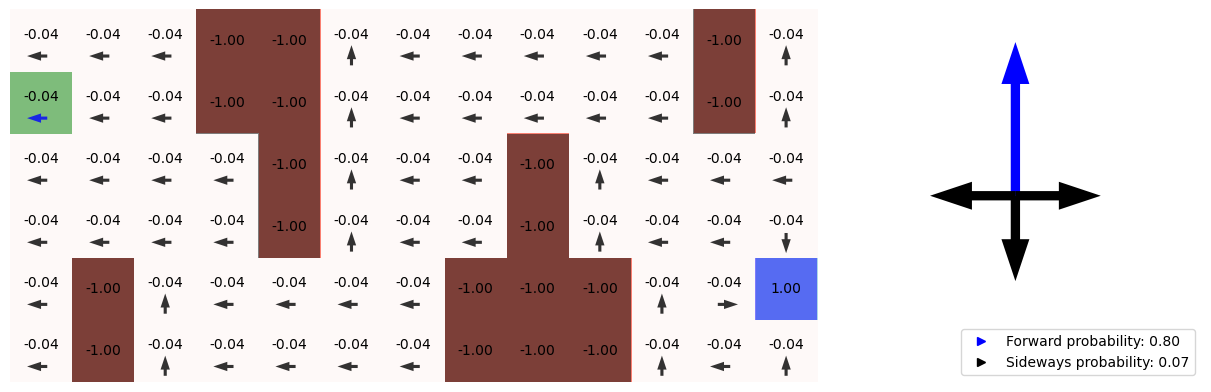

In [59]:
visualizer.iteration_plot(iteration=1,
                          obstacle_reward=-1.0,
                          finish_reward=1.0,
                          empty_reward=-0.04,
                          forward_prob=0.8,
                          gamma=0.9,
                          epsilon=1e-3)

Let's tweak different hyperparameters. First of all, we can adjust our gamma value to be higher, making the agent more motivated go into danger, as it will consider long-term rewards more attractive: $$gamma \leftarrow 0.95$$

After making our agent more motivated, we see that it immediately becomes eager to take risks and go into danger. We acquire proper policy, which leads to the finish terminal state from the start state. 

However it also seems that the agent is not very concerned with obstacles and does not try to keep some distance from them. 

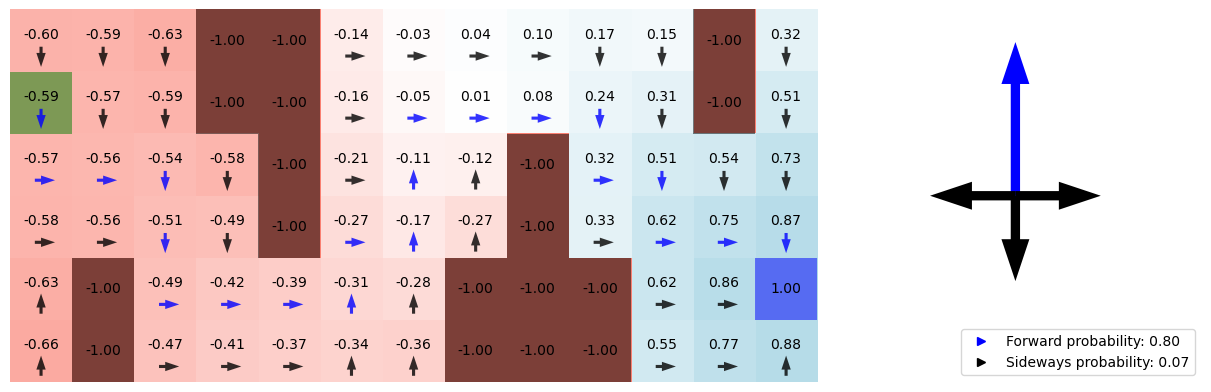

In [60]:
visualizer.iteration_plot(**{'empty_reward': -0.040000000000000036,
                             'epsilon': 0.0009999999999999998,
                             'finish_reward': 1.0,
                             'forward_prob': 0.8,
                             'gamma': 0.9500000000000002,
                             'iteration': 48,
                             'obstacle_reward': -1.0})

Let's make our drone less certain with its stability: $$forward\_prob \leftarrow 0.65$$


Now, when it takes move forward, there is 35% chance that it will make sideways move instead.

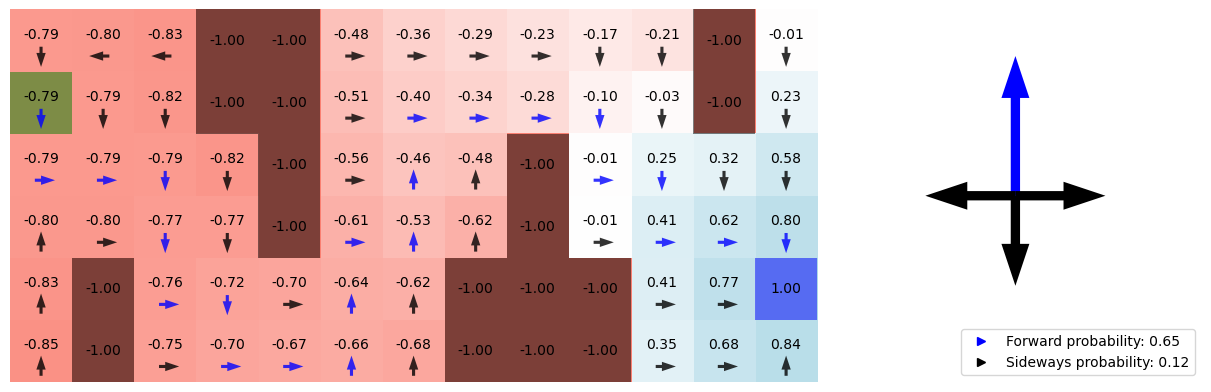

In [61]:
visualizer.iteration_plot(**{'empty_reward': -0.040000000000000036,
                             'epsilon': 0.0009999999999999998,
                             'finish_reward': 1.0,
                             'forward_prob': 0.65,
                             'gamma': 0.9500000000000002,
                             'iteration': 84,
                             'obstacle_reward': -1.0}
                          )

We see that now it keeps some distance from the first stalactite, but does not keep safe distance with the second stalagmite, because the reward is so close and making longer move upward will be less rewarding. 

Now we will try to fix this by tweaking the **empty_reward** hyperparameter: $$empty\_reward \leftarrow 0.00$$


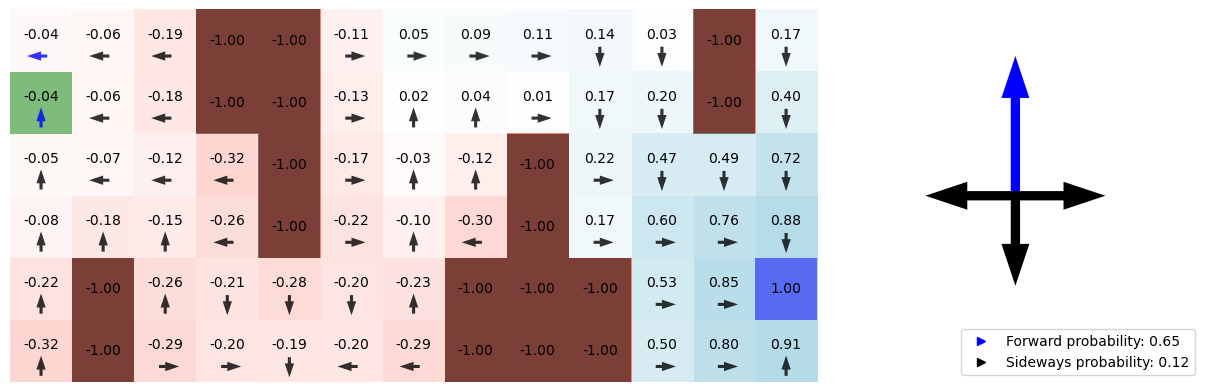

In [62]:
visualizer.iteration_plot(**{'empty_reward': 0.0,
                             'epsilon': 0.0009999999999999998,
                             'finish_reward': 1.0,
                             'forward_prob': 0.65,
                             'gamma': 0.9500000000000002,
                             'iteration': 78,
                             'obstacle_reward': -1.0}
                          )

Again, agent is scared to approach obstacles, staying in environment is not painful, so it prefers just to stay. We will make him super motivated: $$gamma \leftarrow 1.0$$

Now we have purely additive rewards and no discount.

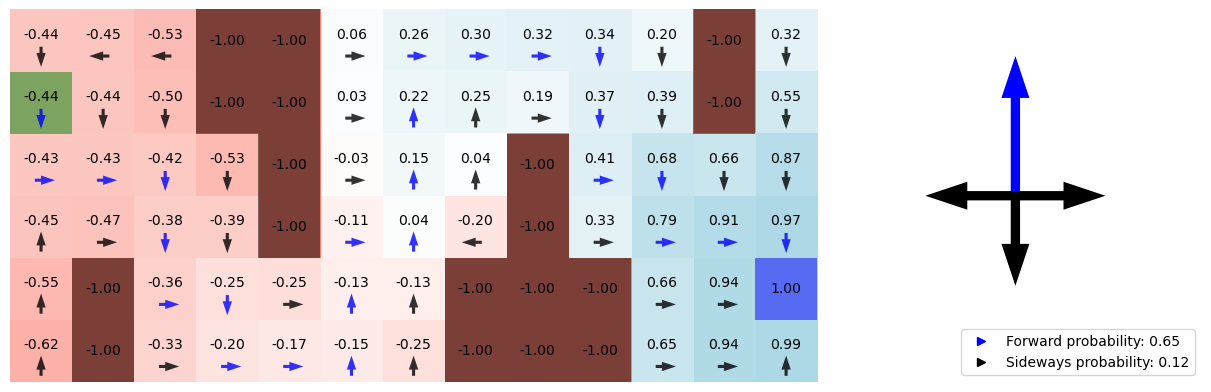

In [63]:
visualizer.iteration_plot(**{'empty_reward': 0.0,
                             'epsilon': 0.0009999999999999998,
                             'finish_reward': 1.0,
                             'forward_prob': 0.65,
                             'gamma': 1.0,
                             'iteration': 372,
                             'obstacle_reward': -1.0}
                          )



Our agent really wants to get to the finish state reward, and staying in the empty state does no pain, so the agent tries to prefer safer route - keeping its distance from obstacles, and still reaching the finish state.

Let's now return penalty for empty states, but make agent absolutely stable: $$empty\_reward \leftarrow -0.04 \\ forward\_prob \leftarrow 1.0$$

The agent is now 100% sure that its movements are stable and will always be in chosen direction, it will not look at all what happens behind, above, or below it, because it is sure it will go forward in the chosen direction each time.

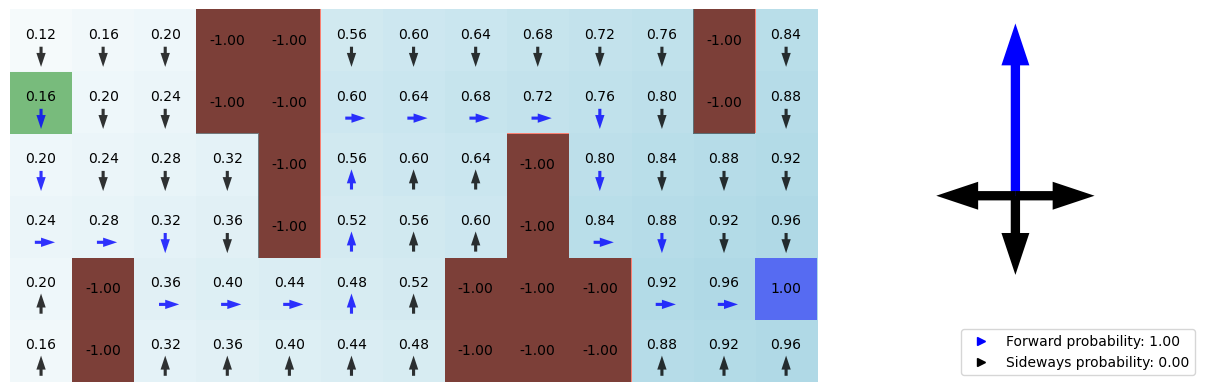

In [64]:
visualizer.iteration_plot(**{'empty_reward': -0.040000000000000036,
                             'epsilon': 1e-06,
                             'finish_reward': 1.0,
                             'forward_prob': 1.0,
                             'gamma': 1.0,
                             'iteration': 24,
                             'obstacle_reward': -1.0}
                          )

The agent takes the shortest possible path to get to the rewarding finish state, and completely neglects the fact that there are obstacles around him. It is sure it will not bump into an obstacle by an accident.

Let's try another interesting situation: $$ forward\_prob \leftarrow 0.8 \\
                                            empty\_reward \leftarrow -0.09 $$



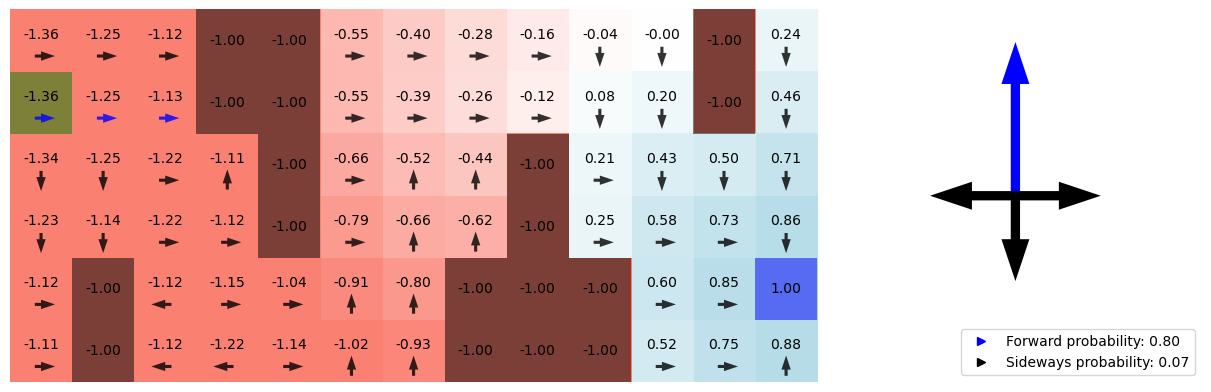

In [65]:
visualizer.iteration_plot(**{'empty_reward': -0.08999999999999997,
                             'epsilon': 0.0009999999999999998,
                             'finish_reward': 1.0,
                             'forward_prob': 0.8,
                             'gamma': 1.0,
                             'iteration': 101,
                             'obstacle_reward': -1.0}
                          )

It is now so painful staying in the environment, that the agent would like to kill itself flying directly to the obstacle.

The last interesting situation occurs, when forward probability is very low: $$forward\_prob \leftarrow 0.1 $$

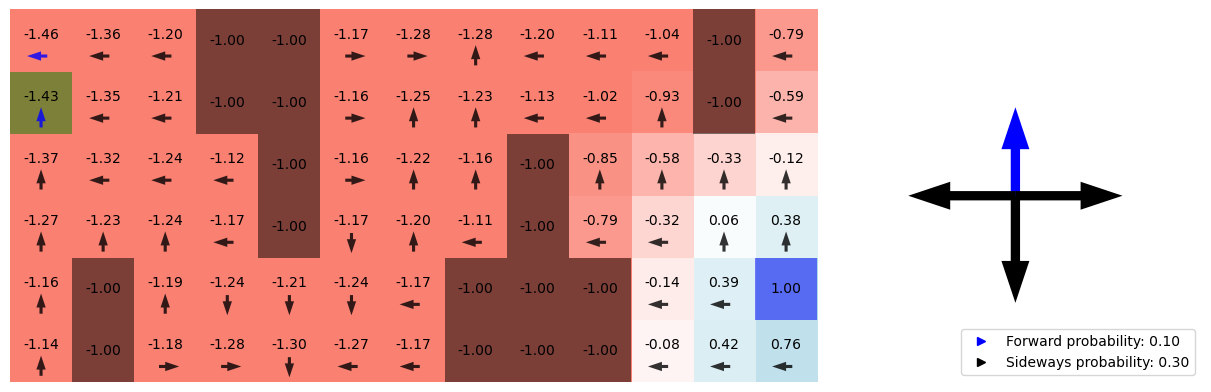

In [66]:
visualizer.iteration_plot(**{'empty_reward': -0.040000000000000036,
                             'epsilon': 0.0009999999999999998,
                             'finish_reward': 1.0,
                             'forward_prob': 0.1,
                             'gamma': 1.0,
                             'iteration': 271,
                             'obstacle_reward': -1.0}
                          )

In this case, the agent is so unstable, that by moving forward there is a higher probability that it will move in another direction. To get to the finish or kill itself, it tries to move in opposite direction.

Now we will observe the medium-sized map:

In [67]:
InteractivePlot(grid_fn=grid_2, hparam_print_button=True).show()

interactive(children=(IntSlider(value=51, description='Iteration', max=51, min=1), FloatSlider(value=-1.0, des…

Button(description='Print hyperparameters', layout=Layout(min_width='300px', width='300px'), style=ButtonStyle…

Output()

At the start, it tries to avoid obstacles, but by the last stalagmite, it has suffered enough and now takes a little risk of collision with the stalagmite's top.

In [68]:
# preparing visualizer instance
visualizer = GridMDPVisualizer(grid_structure_fn=grid_2,
                               iteration_algorithm_fn=value_iteration
                               )

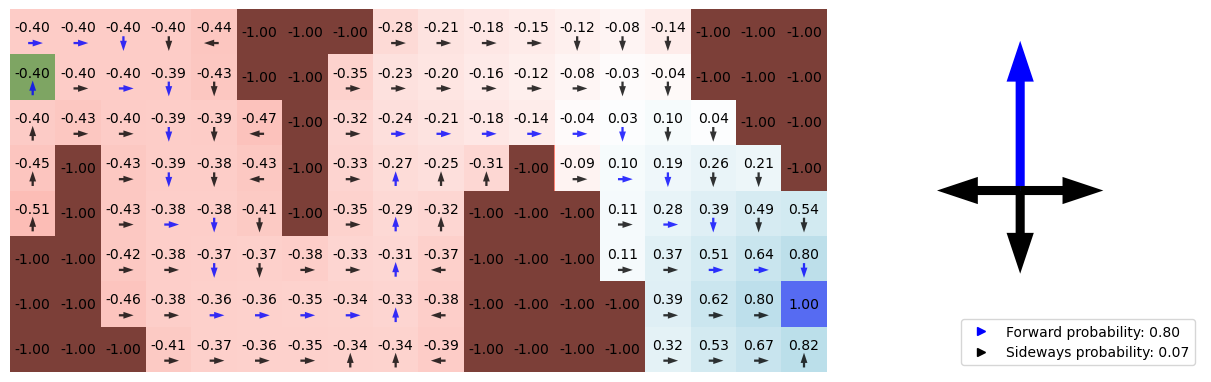

In [69]:
visualizer.iteration_plot(**{'empty_reward': -0.040000000000000036,
                             'epsilon': 0.0009999999999999998,
                             'finish_reward': 1.0,
                             'forward_prob': 0.8,
                             'gamma': 0.9000000000000001,
                             'iteration': 51,
                             'obstacle_reward': -1.0}
                          )

Adjusting gamma hyperparameter and empty reward state, we have a quite secure path:

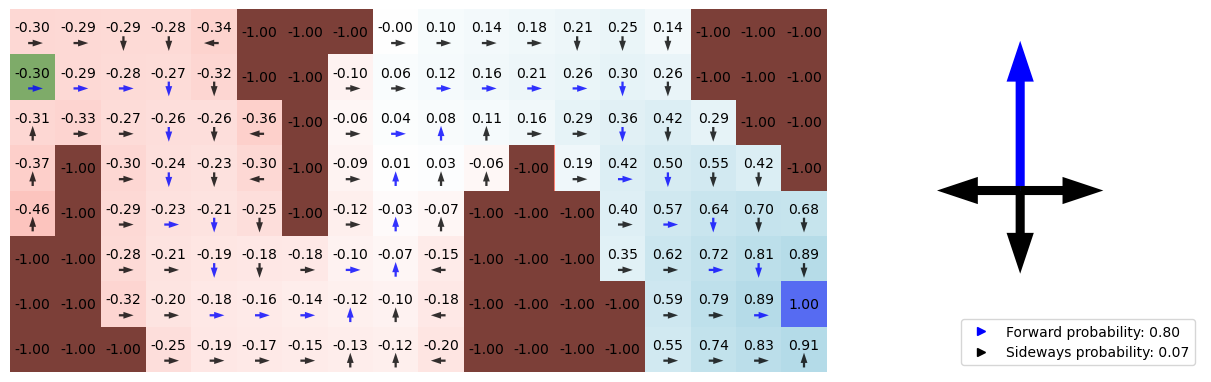

In [70]:
visualizer.iteration_plot(**{'empty_reward': -0.020000000000000018,
                             'epsilon': 0.0009999999999999998,
                             'finish_reward': 1.0,
                             'forward_prob': 0.8,
                             'gamma': 0.9500000000000002,
                             'iteration': 66,
                             'obstacle_reward': -1.0})

Now lets experiment with the largest map.

In [71]:
InteractivePlot(grid_fn=grid_3, hparam_print_button=True).show()

interactive(children=(IntSlider(value=52, description='Iteration', max=52, min=1), FloatSlider(value=-1.0, des…

Button(description='Print hyperparameters', layout=Layout(min_width='300px', width='300px'), style=ButtonStyle…

Output()

Let's adjust forward probability: $$forward\_prob \leftarrow 1.0$$

In [72]:
# preparing visualizer instance
visualizer = GridMDPVisualizer(grid_structure_fn=grid_3,
                               iteration_algorithm_fn=value_iteration
                               )

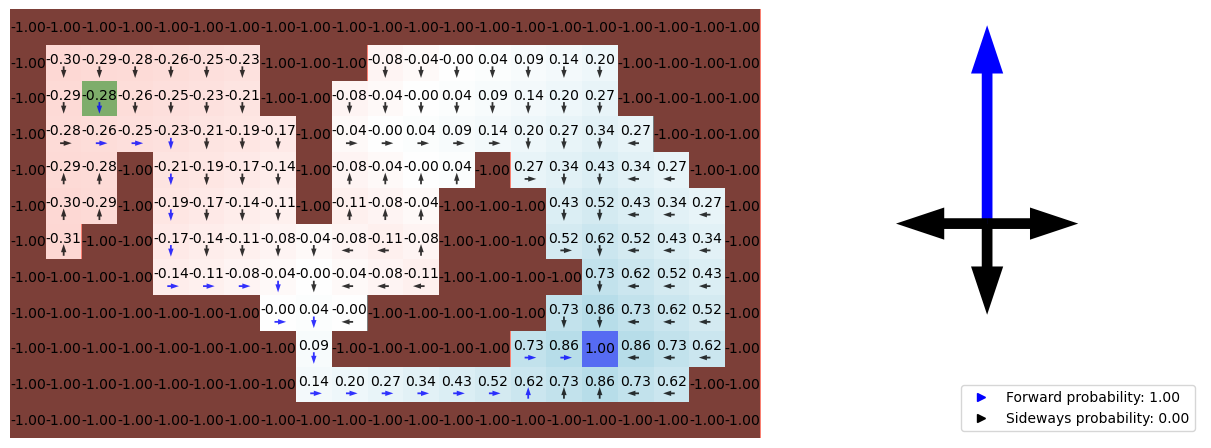

In [73]:
visualizer.iteration_plot(**{'empty_reward': -0.040000000000000036,
                             'epsilon': 0.0009999999999999998,
                             'finish_reward': 1.0,
                             'forward_prob': 1.0,
                             'gamma': 0.9000000000000001,
                             'iteration': 28,
                             'obstacle_reward': -1.0})

The agent chooses the shortest path possible, because it is sure it will not slide sideways accidentally.

Now we will try to adjust hyperparameters to have the safest route:

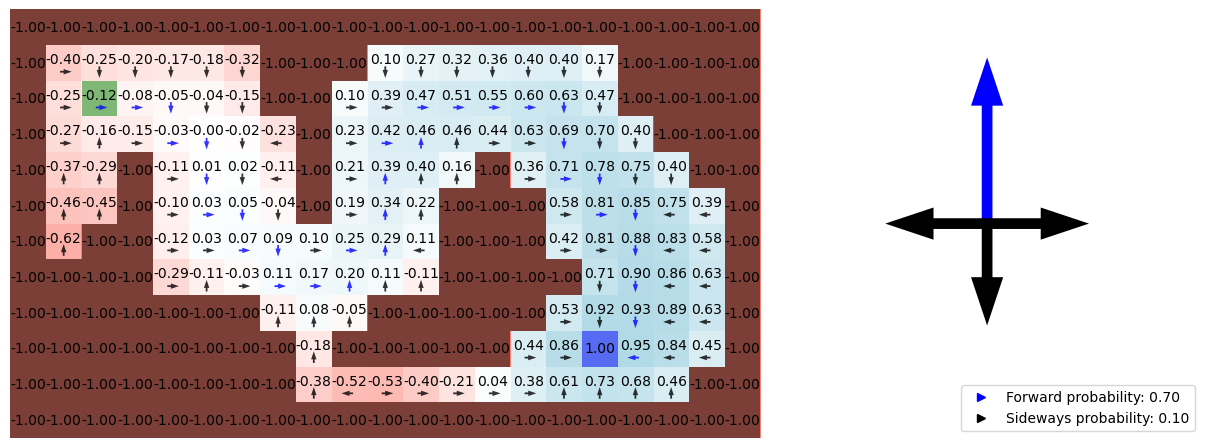

In [74]:
visualizer.iteration_plot(**{'empty_reward': 0.0,
                             'epsilon': 0.0009999999999999998,
                             'finish_reward': 1.0,
                             'forward_prob': 0.7,
                             'gamma': 1.0,
                             'iteration': 247,
                             'obstacle_reward': -1.0})

# References

- Artificial Intelligence A Modern Approach Fourth Edition - Stuart Russell & Peter Norvig
- [Python implementation of algorithms from Russell And Norvig's "Artificial Intelligence - A Modern Approach"](https://github.com/aimacode/aima-python/tree/master)